In [1]:
from modules.settings import global_mmf_settings as gset
from data_preprocess import preprocess_planck_data_esz_cat as ppd
from modules.simulate.spatial_template import sz_pressure_profile as szp
from simulate import cluster_templates as cltemp
from flat_sky_codes import flat_sky_analysis as fsa
from filters import modular_multi_matched_filter as mmf
from masking import gen_masks as gm
from data_preprocess import get_tangent_planes as gtp
from flat_sky_codes import tangent_plane_analysis as tpa
from simulate.spatial_template import sim_cluster as sc
from cosmology import cosmo_fn
import numpy as np
import bces.bces as bces
from astropy.io import fits
import os
from scipy.optimize import curve_fit
%pylab notebook

# def return_log_err(gauss_mean,gauss_err,num_samples=20000):
#     logerr=np.zeros_like(gauss_mean)
#     for idx, mu in enumerate(gauss_mean):
#         x=np.random.normal(mu,gauss_err[idx],num_samples)
#         logerr[idx]=np.std(log10(x))
#     return logerr

def return_log_err(gauss_mean,gauss_err,num_samples=20000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(log10(x))
    return logerr

Populating the interactive namespace from numpy and matplotlib


In [2]:
outpath="/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/results/planck_esz/"
gset.setup_mmf_config(outpath=outpath,chmin=100.,xsize=10.,result_midfix="blind")
figpath=gset.mmfset.paths["result_figs"]
xsz_cat=ppd.get_tangent_plane_fnames()
#ppd.extract_tangent_planes()
conv_Y5R500_SPHR500=szp.convert_Ycyl_xR500_Ysph_xR500()

In [3]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=1.,T_step=1.,theta500_min=2.,theta500_max=55.,theta_step=1.)
tmplt.setup_templates()

In [4]:
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [5]:
xsz_cat["est_Y500_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["otheta500"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)

cmask=gm.return_center_mask()
emask=gm.return_edge_apodized_mask(15.,20.)
for idx,filename in enumerate(xsz_cat["FILENAME"]):
    T500=xsz_cat["T500"][idx]
    glon=xsz_cat["GLON"][idx]
    glat=xsz_cat["GLAT"][idx]
    redshift=xsz_cat["z"][idx]
    projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
    ix,iy=projop.ang2ij(glon,glat)
    
    data=gtp.return_data(filename)
    ps_mask=gtp.return_ps_mask(filename)
    op.get_data_ft(data*ps_mask*emask,smwin=5)
    err,snr_max0,yc,otheta500,ans0=op.return_optimal_theta500(Tc=0.)
    xsz_cat["otheta500"][idx]=otheta500
    
    template=tmplt.gen_template(thetac=otheta500)
    template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)

    temp=tmplt.sz_op.bp_fn_sz_2d_T(0,gset.mmfset.channels)[:,0]
    szspec={}
    for i,ch in enumerate(gset.mmfset.channels):
        szspec[ch]=temp[i]

    temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,gset.mmfset.channels)[:,0]
    szspecT={}
    for i,ch in enumerate(gset.mmfset.channels):
        szspecT[ch]=temp[i]
        
    fdata,err=op.evaluate_mmf(template_ft,szspec)
    yc=max((fdata*cmask).ravel())
    cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_T0=err*Y500_T0/yc
    xsz_cat["est_Y500_T0"][idx]=Y500_T0
    xsz_cat["est_Y500_err_T0"][idx]=Y500_err_T0
    
    op.get_data_ft(data*ps_mask*emask,smwin=5)
    fdata,err=op.evaluate_mmf(template_ft,szspecT)
    #yc=fdata[ix,iy]
    yc=max((fdata*cmask).ravel())
    cluster=sc.gen_field_cluster_template(ix,iy,otheta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_TT=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_TT=err*Y500_TT/yc
    xsz_cat["est_Y500_TT"][idx]=Y500_TT
    xsz_cat["est_Y500_err_TT"][idx]=Y500_err_TT
    
    print xsz_cat["YSZ_500"][idx],xsz_cat["YSZ_500_err"][idx],Y500_T0,Y500_TT,otheta500,xsz_cat["theta500"][idx]
hdu0=fits.PrimaryHDU()
hdu_list=[]
hdu_list=append(hdu_list,hdu0)
filename=gset.mmfset.paths["result_data"] + "blind_xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
for key in xsz_cat.keys():
    if key!="FILENAME":
        temp_hdu = fits.ImageHDU()
        temp_hdu.header["EXTNAME"]=key
        temp_hdu.data=xsz_cat[key]
        hdu_list=append(hdu_list,temp_hdu)
hdu=fits.HDUList([hdu for hdu in hdu_list])

hdu.writeto(filename,overwrite=True)    

0.000174 2.1e-05 0.000185484448955 0.000207587220177 6.66866866867 5.00112063533
4.7e-05 5e-06 8.99249084778e-05 9.74621071296e-05 34.2032032032 19.8187615582
0.00014 1.7e-05 9.45715588635e-05 0.000102498666443 3.48548548549 4.39222522313
2.7e-05 3e-06 6.63578860076e-05 7.19933264063e-05 46.034034034 21.4310982867
8.6e-05 1.3e-05 0.000111468221269 0.000121161985368 5.60760760761 4.75481453727
8.3e-05 8e-06 0.000274624533525 0.000300836293116 37.9169169169 15.8613241811
0.000109 1.3e-05 0.000156203490602 0.000175088119458 9.48048048048 4.98912619678
1.8e-05 3e-06 2.37971138004e-05 2.55925907327e-05 17.8098098098 13.2419756481
3.5e-05 3e-06 7.34590743649e-05 7.91408310055e-05 30.012012012 16.1602051154
9.2e-05 8e-06 8.54600515993e-05 9.31268231925e-05 12.8228228228 13.4300077511
9e-05 7e-06 0.000186611952178 0.000208151799643 36.0600600601 19.773666777
9.9e-05 1.4e-05 0.00013434337141 0.000149132411012 8.04804804805 6.61514694671
0.000129 1e-05 0.000226961023505 0.00025259849714 9.109109

In [13]:
#filename=gset.mmfset.paths["result_data"] + "xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
filename="../results/planck_esz/results/10deg_patches/data/" + "xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
f1=fits.open(filename)
fxsz_cat={}
for i in range(len(f1)-1):
    key=f1[i+1].header["EXTNAME"]
    fxsz_cat[key]=f1[i+1].data
    
filename=gset.mmfset.paths["result_data"] +  "blind_xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
f1=fits.open(filename)
xsz_cat={}
for i in range(len(f1)-1):
    key=f1[i+1].header["EXTNAME"]
    xsz_cat[key]=f1[i+1].data
    
# for idx in range(len(bxsz_cat["z"])):
#     print fxsz_cat["YSZ_500"][idx],fxsz_cat["YSZ_500_err"][idx],fxsz_cat["est_Y500_T0"][idx],fxsz_cat["est_Y500_err_T0"][idx],fxsz_cat["est_Y500_TT"][idx],fxsz_cat["est_Y500_err_TT"][idx]

<IPython.core.display.Javascript object>


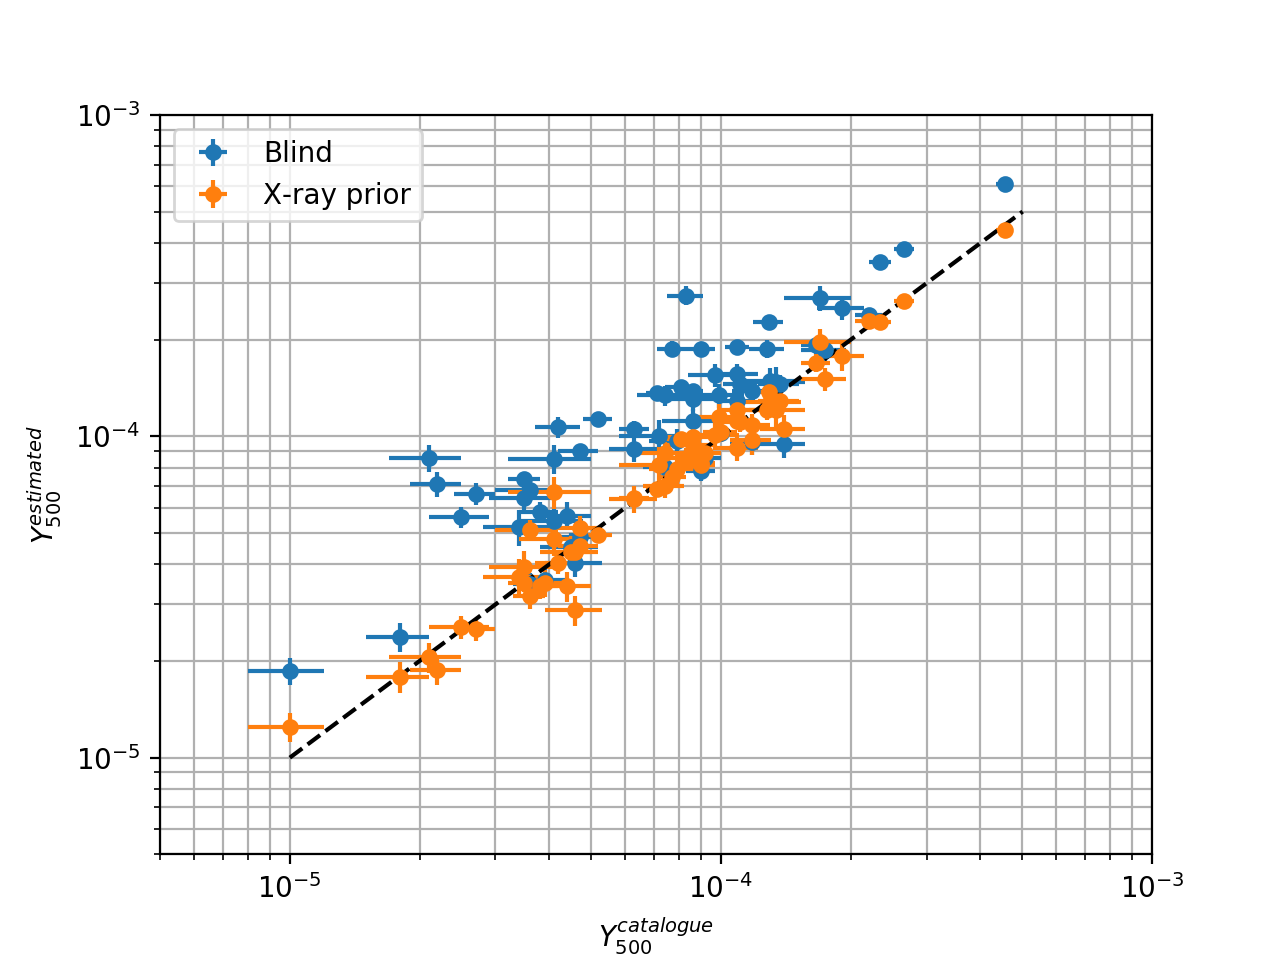

In [14]:
x=logspace(-5,-3.3,100)
figure()
errorbar(xsz_cat["YSZ_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YSZ_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Blind")
errorbar(fxsz_cat["YSZ_500"],fxsz_cat["est_Y500_T0"],xerr=fxsz_cat["YSZ_500_err"],yerr=fxsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="X-ray prior")
plot(x,x,"k--")
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0)
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

In [28]:
fn=lambda x,a: 1.+a*x/5.
slope_err,temp=curve_fit(fn,fxsz_cat["T500"],fxsz_cat["est_Y500_err_TT"]/fxsz_cat["est_Y500_err_T0"])
slope_y,temp=curve_fit(fn,fxsz_cat["T500"],fxsz_cat["est_Y500_TT"]/fxsz_cat["est_Y500_T0"])

<IPython.core.display.Javascript object>


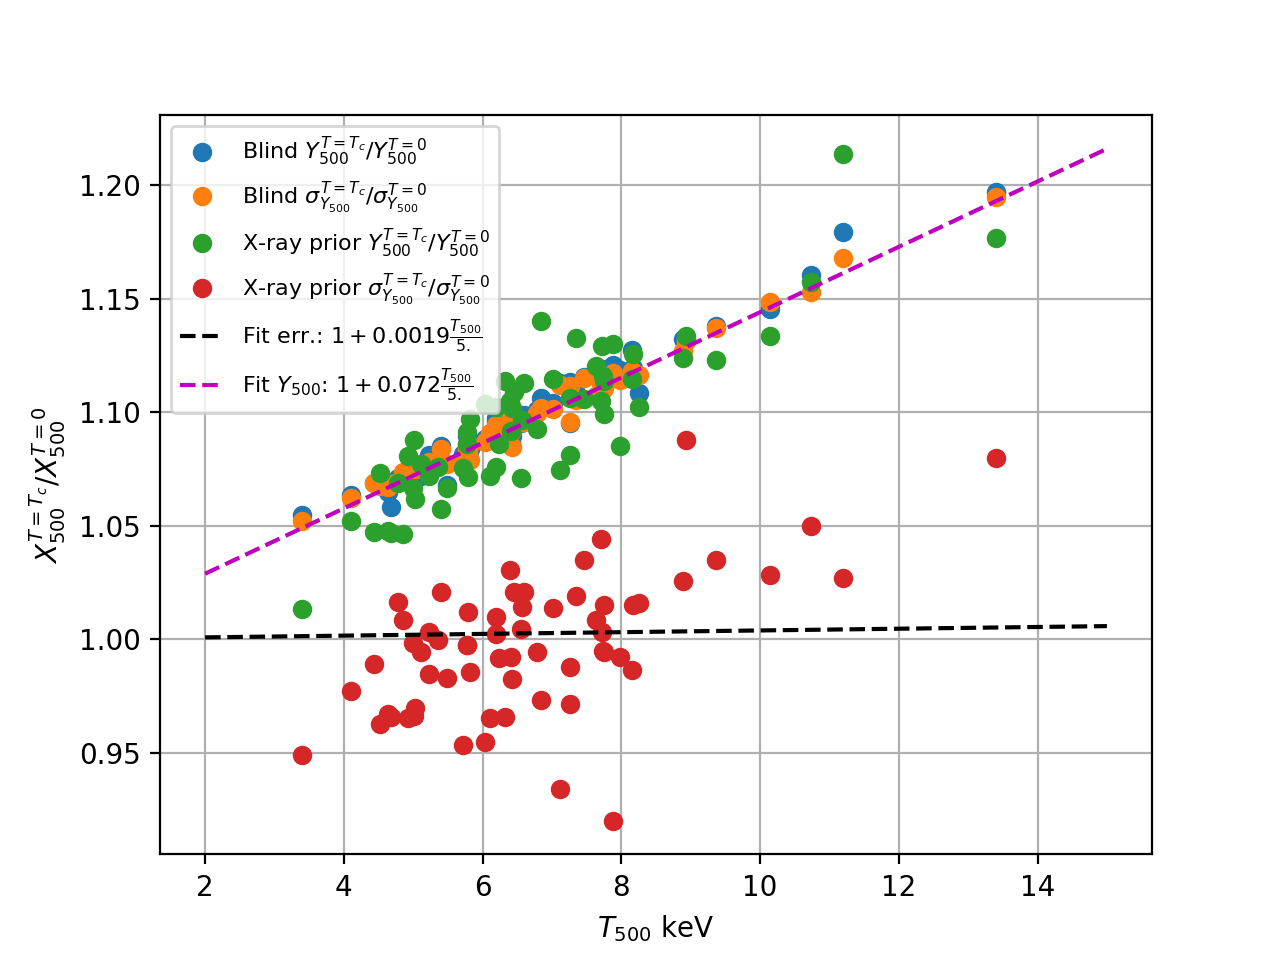

In [37]:
figure()
plot(xsz_cat["T500"],xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_T0"],"o",label="Blind $Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
plot(xsz_cat["T500"],xsz_cat["est_Y500_err_TT"]/xsz_cat["est_Y500_err_T0"],"o",label="Blind $\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(fxsz_cat["T500"],fxsz_cat["est_Y500_TT"]/fxsz_cat["est_Y500_T0"],"o",label="X-ray prior $Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
plot(fxsz_cat["T500"],fxsz_cat["est_Y500_err_TT"]/fxsz_cat["est_Y500_err_T0"],"o",label="X-ray prior $\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")

T500=linspace(2.,15,100)
plot(T500,fn(T500,slope_err),"k--",label="Fit err.: " + r"$1 + $" + str(round(slope_err,4)) + r"$\frac{T_{500}}{5.}$")
plot(T500,fn(T500,slope_y),"m--",label=r"Fit $Y_{500}$: " + "$1 + $" + str(round(slope_y,4)) + r"$\frac{T_{500}}{5.}$")

xlabel('$T_{500}$ keV')
ylabel('$X^{T=T_c}_{500}/X^{T=0}_{500}$')
grid()
legend(loc=0,fontsize=8)
figname=figpath + "rSZ_correction_Y500_vs_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


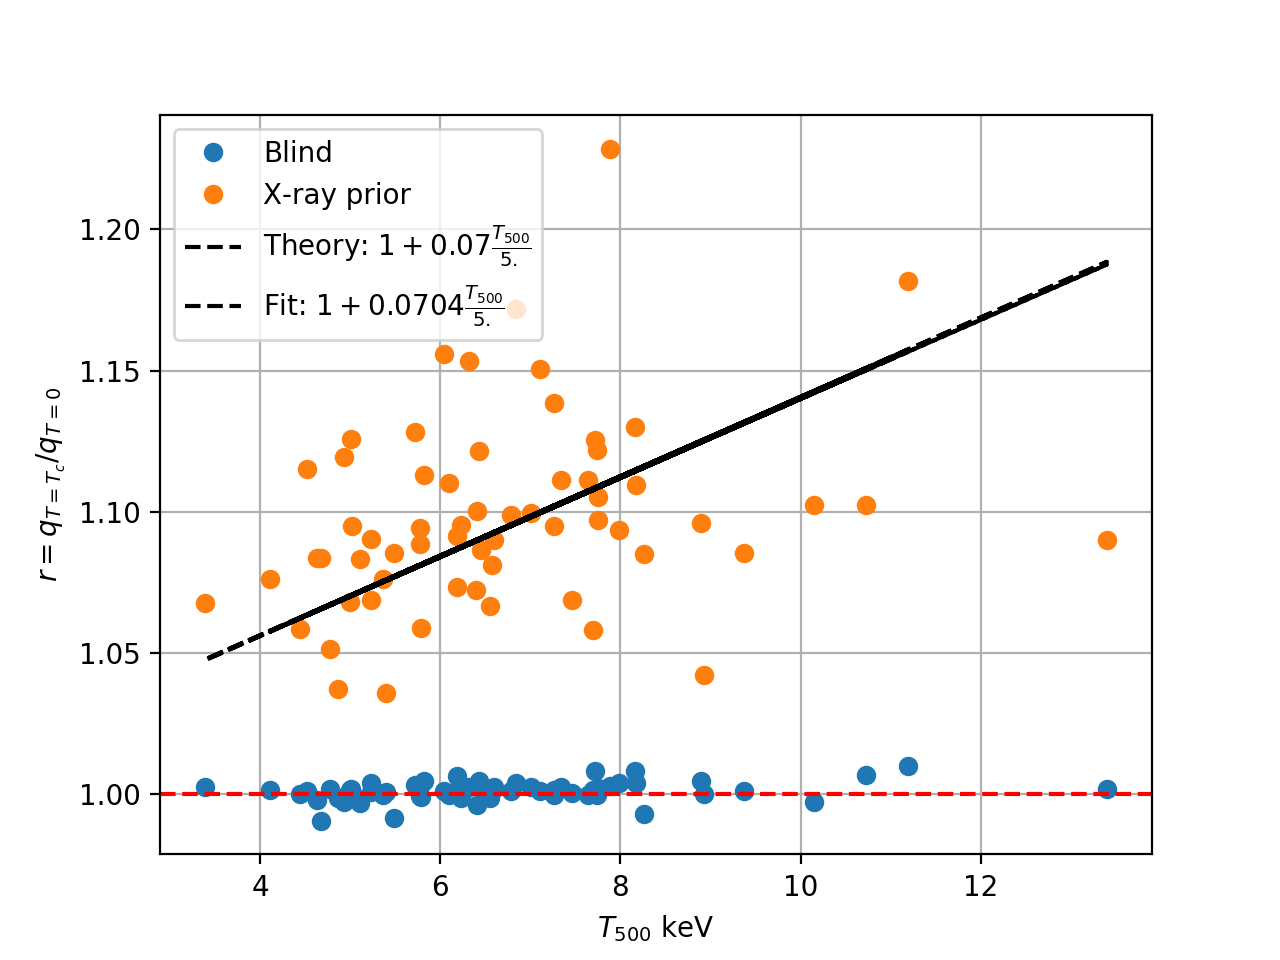

In [50]:
qT0=xsz_cat["est_Y500_T0"]/xsz_cat["est_Y500_err_T0"]
qTT=xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_err_TT"]
fqT0=fxsz_cat["est_Y500_T0"]/fxsz_cat["est_Y500_err_T0"]
fqTT=fxsz_cat["est_Y500_TT"]/fxsz_cat["est_Y500_err_TT"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,fxsz_cat["T500"],fqTT/fqT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o",label="Blind")
plot(xsz_cat["T500"],fqTT/fqT0,"o",label="X-ray prior")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"Theory: $1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
axhline(1,c="r",ls="--")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"
savefig(figname,bbox_inches="tight")

In [51]:
fn(xsz_cat["T500"],slope)

array([ 1.108624  ,  1.0813273 ,  1.08189011,  1.07598052,  1.09019169,
        1.10215159,  1.11087527,  1.07063374,  1.07035233,  1.0904731 ,
        1.10496568,  1.10890541,  1.10004102,  1.08498562,  1.09624199,
        1.08582984,  1.04769888,  1.0693674 ,  1.10215159,  1.15744852,
        1.10749836,  1.12564926,  1.09539776,  1.08048307,  1.06514626,
        1.07724686,  1.10904611,  1.09244296,  1.14281523,  1.09075451,
        1.08892535,  1.05782962,  1.06838247,  1.06247287,  1.07190008,
        1.07358854,  1.11495571,  1.06725683,  1.09216155,  1.09286508,
        1.11622205,  1.09863397,  1.10834259,  1.0754177 ,  1.18854425,
        1.10904611,  1.07358854,  1.13184027,  1.09005098,  1.081468  ,
        1.0813273 ,  1.087659  ,  1.12508645,  1.08709619,  1.06584978,
        1.08709619,  1.114815  ,  1.10327722,  1.11228232,  1.06359851,
        1.1509761 ,  1.07049304])

In [53]:
print sum((fn(xsz_cat["T500"],slope)-fqTT/fqT0)**2)
print sum((1.-fqTT/fqT0)**2)

0.0837080615852
0.673473438922


In [17]:
ints_sample = fits.open(gset.mmfset.union_cat_file)
keys_ints=ints_sample['PSZ2_UNION'].header.keys()
fkeys_ints=[k for k in keys_ints if "TTYPE" in k]
fields_ints=[ints_sample['PSZ2_UNION'].header[tkeys] for tkeys in fkeys_ints]
ints_raw={}
for n in fields_ints:
    if n=="NAME":
        ints_raw[n]=list(ints_sample['PSZ2_UNION'].data.field(n).flatten())
    else:
        ints_raw[n]=ints_sample['PSZ2_UNION'].data.field(n).flatten()

In [18]:
xsz_cat["ints_z"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_YSZ_500"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_YSZ_500_err"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_snr"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_cosmo"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)

thr=0.2
for idx, glon in enumerate(xsz_cat["GLON"]):
    glat=xsz_cat["GLAT"][idx]
    for jdx, ints_glon in enumerate(ints_raw["GLON"]):
        ints_glat=ints_raw["GLAT"][jdx]
        if (abs(ints_glat-glat)<thr) & (abs(ints_glon-glon)<thr):
            xsz_cat["ints_z"][idx]=ints_raw["REDSHIFT"][jdx]
            xsz_cat["ints_YSZ_500"][idx]=ints_raw["Y5R500"][jdx]
            xsz_cat["ints_YSZ_500_err"][idx]=ints_raw["Y5R500_ERR"][jdx]
            xsz_cat["ints_snr"][idx]=ints_raw["SNR"][jdx]
            xsz_cat["ints_cosmo"][idx]=ints_raw["COSMO"][jdx]
            #print idx,jdx,glon,ints_glon,glat,ints_glat,xsz_cat["ints_z"][idx],xsz_cat["z"][idx]
            
xsz_cat["ints_YSZ_500"]=(cosmo_fn.dA(xsz_cat["ints_z"])**2.)*xsz_cat["ints_YSZ_500"]*(10**(-3.))*((np.pi/180./60.)**2.)*cosmo_fn.conv_y2y500
xsz_cat["ints_YSZ_500_err"]=(cosmo_fn.dA(xsz_cat["ints_z"])**2.)*xsz_cat["ints_YSZ_500_err"]*(10**(-3.))*((np.pi/180./60.)**2.)*cosmo_fn.conv_y2y500

<IPython.core.display.Javascript object>


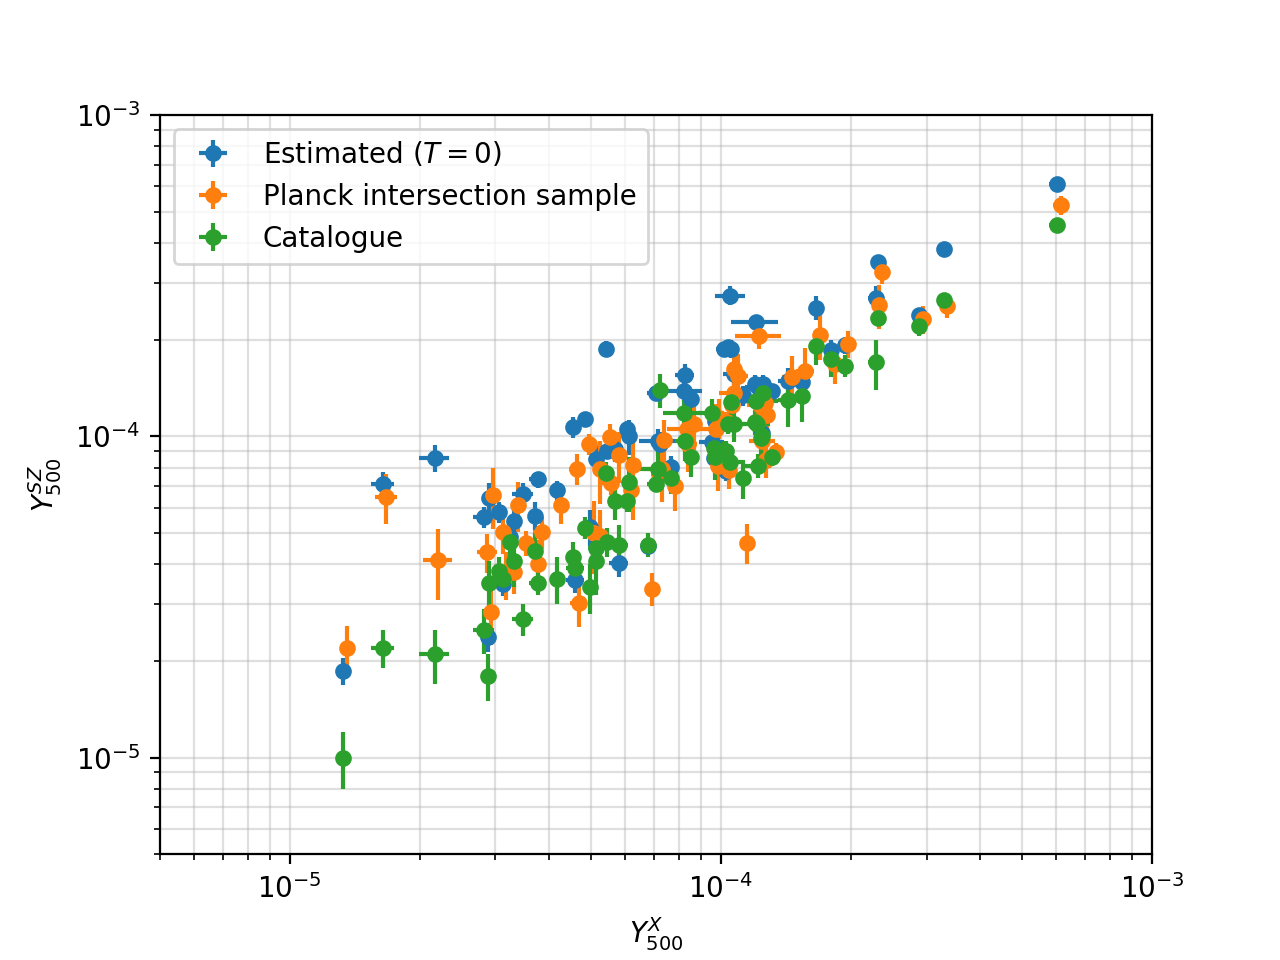

In [19]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["ints_YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["ints_YSZ_500_err"],fmt='o',ms=5,label="Planck intersection sample")
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)

<IPython.core.display.Javascript object>


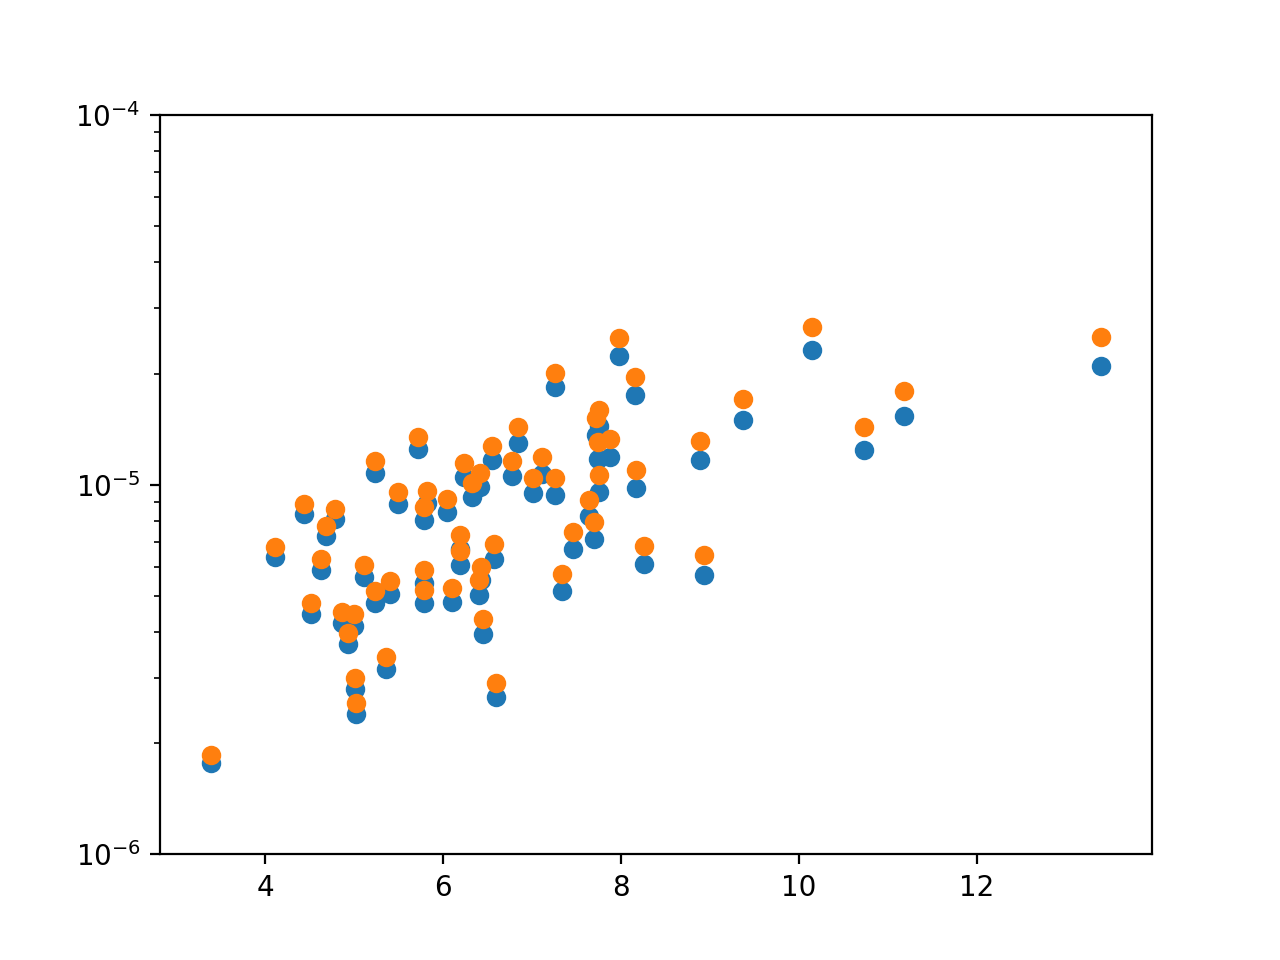

(1e-06, 0.0001)

In [60]:
figure()
scatter(xsz_cat["T500"],xsz_cat["est_Y500_err_T0"])
scatter(xsz_cat["T500"],xsz_cat["est_Y500_err_TT"])
semilogy()
ylim(1e-6,1e-4)